# Set up Google Colab

This means mounting drive and importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.

# %cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME
#!pip install
#4/1AY0e-g5h4eZedG3k6mfdIj0OYbR717PFyEhKuxK5PidsrBbPRxi8fge6E3c

Mounted at /content/drive
/content/drive/My Drive/Lab/Grain-U-Net


In [ ]:
from Model import *
#import Model
import data
import keras

# Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [3]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.00,
                    height_shift_range=0.00,
                    shear_range=0.00,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
save_to_dir = None #'data/train/aug'
myGene = data.trainGenerator(2,'data/train','image','label',data_gen_args, save_to_dir = save_to_dir)
model = unet()
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_grain.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene, steps_per_epoch=2000, epochs=3, callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 54 images belonging to 1 classes.
Found 54 images belonging to 1 classes.
Epoch 1/3
  33/2000 [..............................] - ETA: 7:36:14 - loss: 0.1244 - accuracy: 0.9827

KeyboardInterrupt: ignored

### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### test your model and save predicted results

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
def test_img(test_path,num_image = 30,target_size = (256, 256),flag_multi_class = False,as_gray = True):
    img_stack = np.zeros((num_image,) + target_size)
    for i in range(num_image):
        img = load_img(os.path.join(test_path,"%d.png"%i), target_size=target_size, color_mode='grayscale')
        img_stack[i] = img / (np.max(img))
    print(np.max(img_stack), np.min(img_stack))
    return img_stack

from skimage import io
import numpy as np
#testGene = data.testGenerator("data/test", target_size=(512,512))
test_set = test_img("data/test", num_image = 23)
model = unet()
model.load_weights("unet_grain.hdf5")
#results = 255 * model.predict_generator(testGene, 23, verbose=1)
results = 255 * model.predict(test_set, 23)
data.saveResult("data/test", results.astype('uint8'))
print(results.shape, np.max(results), np.min(results))
io.imshow(results[22, :, :, 0])

# Small Post Processing Stage

This next thing is just to visualize what the processing is doing before applying it to all the images

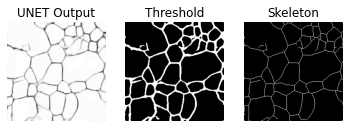

In [ ]:
from skimage import data, io, filters, morphology
import numpy as np
import matplotlib.pyplot as plt

def imsubplot(ax, im, cmap="gray", title=None):
    ax.imshow(im, cmap=cmap)
    ax.axis("off")
    if title:
        ax.set_title(title)

def post_process(path, thresh=255, verbose=False):
    image = io.imread(path)
    threshold = np.zeros(image.shape)
    threshold[image < thresh] = 1
    skeleton = morphology.skeletonize(threshold)
    
    if verbose:
        fig, (a, b, c) = plt.subplots(ncols=3)
        
        imsubplot(a, image, title='UNET Output')
        imsubplot(b, threshold, title='Threshold')
        imsubplot(c, skeleton, title='Skeleton')
        plt.show()
    else:
        return skeleton

post_process('data/test/0_predict.png', thresh=250, verbose=True)

#### This is to apply this processing to all the boundaries

In [ ]:
test_n = 23
test_dir = 'data/test/'

for i in range(test_n):
    im_path = f'{test_dir}{i}_predict.png'
    skel = 255 * post_process(im_path, thresh=250)
    io.imsave(f'{test_dir}{i}_processed.png', skel.astype('uint8')) 

# Overlay 

In [ ]:
from skimage import io, transform
import numpy as np
import os

test_n = 23
test_dir = 'data/test/'

for i in range(test_n):
    raw_img = io.imread(f'{test_dir}{i}.png')
    sk_img = io.imread(f'{test_dir}{i}_processed.png')
    sk_img = 255 * transform.resize(sk_img, raw_img.shape, anti_aliasing=False)
    fusion_img = np.zeros((raw_img.shape[0], raw_img.shape[1], 3), dtype=int)
    fusion_img[:, :, 0] = raw_img
    fusion_img[:, :, 1] = raw_img
    fusion_img[:, :, 2] = raw_img
    fusion_img[sk_img > 0, 0] = 255
    if os.path.isfile(f'{test_dir}key/{i}.png'):
        ht_img = 255 * io.imread(f'{test_dir}key/{i}.png')
        fusion_img[ht_img > 0, 1] = 255

    io.imsave(f'{test_dir}{i}_overlaid.png', fusion_img.astype('uint8')) 
#    io.imshow(fusion_img)
#    io.show()

# Chi2

In [ ]:
from chi2test import find_chi2
from skimage import io, transform
import os
import numpy as np
import time

test_dir = 'data/test/'
traced_dir = 'data/test/key/'
traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

chi2_dtype = [('img', (np.str_, 10)), ('chi2', np.float64), ('avg_chi2', np.float64)]
results = np.array([], dtype=chi2_dtype)

for key in traced:
    ml_img = io.imread(test_dir + key + '_processed.png')
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)

    if np.min(key_img) != 0 or np.max(key_img) != 255:
        key_img -= np.min(key_img)
        key_img = np.round(key_img * (255 / np.max(key_img)))
    key_img = np.max(key_img) - key_img
    
    result = find_chi2(ml_img, key_img, out_dict=True)
    results = np.append(results, \
                np.array([(key, result["chi2"], result["avg_chi2"])], dtype=chi2_dtype))
    print(f'img: {key} \t chi2: {result["chi2"]} \t avg_chi2: {result["avg_chi2"]}')

print(f'\nAverage chi2: {np.mean(results["chi2"])}\nAverage avg_chi2: {np.mean(results["avg_chi2"])}\n')
print(f'Max chi2: {np.max(results["chi2"])}\nMin chi2: {np.min(results["chi2"])}')

img: 0 	 chi2: 27957 	 avg_chi2: 10.819272445820433
img: 1 	 chi2: 26409 	 avg_chi2: 8.478009630818619
img: 10 	 chi2: 128980 	 avg_chi2: 38.83769948810599
img: 11 	 chi2: 287066 	 avg_chi2: 103.00179404377467
img: 12 	 chi2: 70778 	 avg_chi2: 29.651445328864682
img: 2 	 chi2: 10442 	 avg_chi2: 3.994644223412395
img: 3 	 chi2: 31761 	 avg_chi2: 11.44953136265321
img: 4 	 chi2: 221860 	 avg_chi2: 96.33521493703864
img: 5 	 chi2: 87223 	 avg_chi2: 27.274233896185116
img: 6 	 chi2: 79038 	 avg_chi2: 30.551990722844995
img: 7 	 chi2: 184143 	 avg_chi2: 52.79329128440367
img: 8 	 chi2: 68769 	 avg_chi2: 23.061368209255534
img: 9 	 chi2: 85555 	 avg_chi2: 30.908598265895954

Average chi2: 100767.76923076923
Average avg_chi2: 35.93516106454415

Max chi2: 287066.0
Min chi2: 10442.0


**Here I'm indicating some of the hyper-parameters "E:[# Epochs] S:[Steps per epoch]"**
## Original Hyperparameters (Jul 9):
- img: 0 	 chi2: 33696 	 avg_chi2: 14.302207130730052
- img: 1 	 chi2: 17453 	 avg_chi2: 5.896283783783784
- img: 2 	 chi2: 2642 	 avg_chi2: 1.110550651534258
- img: 3 	 chi2: 36192 	 avg_chi2: 14.570048309178745
- img: 4 	 chi2: 166350 	 avg_chi2: 85.2202868852459
- img: 5 	 chi2: 55402 	 avg_chi2: 19.562853107344633
- img: 6 	 chi2: 32097 	 avg_chi2: 14.88038942976356
- img: 7 	 chi2: 108598 	 avg_chi2: 36.63900134952767
- img: 8 	 chi2: 38225 	 avg_chi2: 14.534220532319392
- img: 9 	 chi2: 45601 	 avg_chi2: 18.052652414885195
- img: 10 	 chi2: 65879 	 avg_chi2: 22.53043775649795
- img: 11 	 chi2: 205932 	 avg_chi2: 81.7514886859865
- img: 12 	 chi2: 36834 	 avg_chi2: 17.674664107485604

Average chi2: 64992.38461538462
Average avg_chi2: 26.671160318791017

Max chi2: 205932.0
Min chi2: 2642.0

## E:3 S:500 (Jul 12)
- img: 0 	 chi2: 104130 	 avg_chi2: 38.681277860326894
- img: 1 	 chi2: 34941 	 avg_chi2: 10.343694493783303
- img: 10 	 chi2: 170994 	 avg_chi2: 48.79965753424658
- img: 11 	 chi2: 392136 	 avg_chi2: 127.8565373328986
- img: 12 	 chi2: 267889 	 avg_chi2: 102.91548213599692
- img: 2 	 chi2: 13565 	 avg_chi2: 5.140204622963243
- img: 3 	 chi2: 53893 	 avg_chi2: 18.164138860802158
- img: 4 	 chi2: 291323 	 avg_chi2: 107.97739065974797
- img: 5 	 chi2: 206559 	 avg_chi2: 60.01133062173155
- img: 6 	 chi2: 117882 	 avg_chi2: 41.98076923076923
- img: 7 	 chi2: 277624 	 avg_chi2: 72.60041841004184
- img: 8 	 chi2: 85928 	 avg_chi2: 26.87769784172662
- img: 9 	 chi2: 213000 	 avg_chi2: 68.75403486120078

Average chi2: 171528.0
Average avg_chi2: 56.16174111278737

Max chi2: 392136.0
Min chi2: 13565.0

## E:5 S:2000 (Jul 12)
- img: 0 	 chi2: 5383 	 avg_chi2: 2.372410753635963
- img: 1 	 chi2: 9893 	 avg_chi2: 3.5106458481192333
- img: 10 	 chi2: 39345 	 avg_chi2: 15.21461716937355
- img: 11 	 chi2: 133482 	 avg_chi2: 60.2627539503386
- img: 12 	 chi2: 29105 	 avg_chi2: 14.895087001023542
- img: 2 	 chi2: 942 	 avg_chi2: 0.4124343257443082
- img: 3 	 chi2: 10375 	 avg_chi2: 4.631696428571429
- img: 4 	 chi2: 127879 	 avg_chi2: 74.34825581395349
- img: 5 	 chi2: 49989 	 avg_chi2: 20.3953488372093
- img: 6 	 chi2: 24439 	 avg_chi2: 11.979901960784314
- img: 7 	 chi2: 59255 	 avg_chi2: 23.825894652191394
- img: 8 	 chi2: 36177 	 avg_chi2: 15.264556962025317
- img: 9 	 chi2: 31360 	 avg_chi2: 13.652590335219852

Average chi2: 42894.153846153844
Average avg_chi2: 20.058938002937712

Max chi2: 133482.0
Min chi2: 942.0

## E:3 S:2000 (Jul 12)
- img: 0 	 chi2: 6038 	 avg_chi2: 2.624076488483268
- img: 1 	 chi2: 11210 	 avg_chi2: 3.9499647639182522
- img: 10 	 chi2: 40489 	 avg_chi2: 15.389205625237553
- img: 11 	 chi2: 184137 	 avg_chi2: 84.5829122645843
- img: 12 	 chi2: 46970 	 avg_chi2: 23.14933464760966
- img: 2 	 chi2: 551 	 avg_chi2: 0.23780750971083298
- img: 3 	 chi2: 13850 	 avg_chi2: 5.664621676891615
- img: 4 	 chi2: 141623 	 avg_chi2: 80.19422423556058
- img: 5 	 chi2: 39474 	 avg_chi2: 15.449706457925636
- img: 6 	 chi2: 23192 	 avg_chi2: 11.578632051922117
- img: 7 	 chi2: 81336 	 avg_chi2: 31.586796116504853
- img: 8 	 chi2: 29735 	 avg_chi2: 12.196472518457751
- img: 9 	 chi2: 32425 	 avg_chi2: 14.128540305010894

Average chi2: 50079.230769230766
Average avg_chi2: 23.13325343552441

Max chi2: 184137.0
Min chi2: 551.0

## E:1 S:2000 (Jul 12)
- img: 0 	 chi2: 27957 	 avg_chi2: 10.819272445820433
- img: 1 	 chi2: 26409 	 avg_chi2: 8.478009630818619
- img: 10 	 chi2: 128980 	 avg_chi2: 38.83769948810599
- img: 11 	 chi2: 287066 	 avg_chi2: 103.00179404377467
- img: 12 	 chi2: 70778 	 avg_chi2: 29.651445328864682
- img: 2 	 chi2: 10442 	 avg_chi2: 3.994644223412395
- img: 3 	 chi2: 31761 	 avg_chi2: 11.44953136265321
- img: 4 	 chi2: 221860 	 avg_chi2: 96.33521493703864
- img: 5 	 chi2: 87223 	 avg_chi2: 27.274233896185116
- img: 6 	 chi2: 79038 	 avg_chi2: 30.551990722844995
- img: 7 	 chi2: 184143 	 avg_chi2: 52.79329128440367
- img: 8 	 chi2: 68769 	 avg_chi2: 23.061368209255534
- img: 9 	 chi2: 85555 	 avg_chi2: 30.908598265895954

Average chi2: 100767.76923076923
Average avg_chi2: 35.93516106454415

Max chi2: 287066.0
Min chi2: 10442.0



## Chi2 Alignment

/home/jamie/.local/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


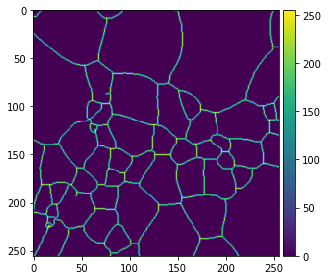

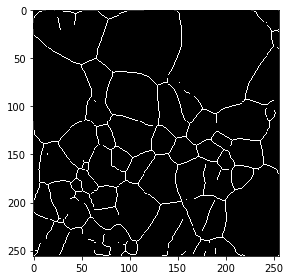

{'x': array([-1.]), 'y': array([1.]), 'chi2': 52921.0, 'avg_chi2': 26460.5}
55402
(260, 260, 3)
1 3 -3 -1
(260, 260, 3)
2 2 -2 -2


/home/jamie/.local/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


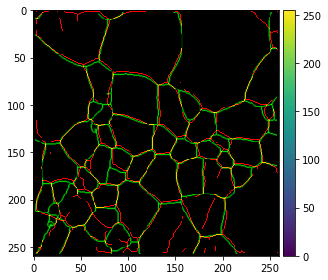

In [ ]:
from chi2test import *
from skimage import io, transform
import numpy as np

traced_n = 13
traced_dir = 'data/test/key/'

ml_img = io.imread('data/test/5_processed.png')
key_img = transform.resize(io.imread('data/test/key/5.png'), ml_img.shape)

if np.min(ml_img) != 0 or np.max(ml_img) != 255:
    ml_img -= np.min(ml_img)
    ml_img = np.round(ml_img * (255 / np.max(ml_img)))
        
if np.min(key_img) != 0 or np.max(key_img) != 255:
    key_img -= np.min(key_img)
    key_img = np.round(key_img * (255 / np.max(key_img)))
    
key_img = 255 - key_img

io.imshow(key_img)
io.show()

io.imshow(ml_img)
io.show()

results = chi2_align(ml_img, key_img)

print(results)

print(find_chi2(ml_img, key_img))

offset_x = int(results["x"])
offset_y = int(results["y"])
fuse_size = np.maximum(key_img.shape, ml_img.shape)
fuse_size[0] += 2 * abs(offset_x) + 2
fuse_size[1] += 2 * abs(offset_y) + 2

def fuse(out, img, offset_x=0, offset_y=0):
    buf_x = out.shape[0] - img.shape[0]
    buf_y = out.shape[1] - img.shape[1]
    img = np.round(img * (255 / np.max(img)))
    x_low = buf_x//2 + offset_x
    y_low = buf_y//2 + offset_y
    x_high = -buf_x//2 + offset_x
    y_high = -buf_y//2 + offset_y
    print(x_low, y_low, x_high, y_high)
    if (x_high > -1):
        x_high = x_low + img.shape[0]
    if (y_high > -1):
        y_high = y_low + img.shape[1]
    out[x_low : x_high, y_low : y_high] = img

fuse_img = np.zeros((fuse_size[0], fuse_size[1], 3), dtype=int)
print(fuse_img.shape)
fuse(fuse_img[:,:,0], ml_img, offset_x, offset_y)
print(fuse_img.shape)
fuse(fuse_img[:,:,1], key_img)

io.imshow(fuse_img)
io.show()
